In [322]:
# import packages
import numpy as np
import seaborn as sns
from scipy.stats import wishart
from scipy.stats import dirichlet
from scipy.stats import expon
import scipy.special as sc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

In [334]:
# set parameters
k0 = 5 # specific topics
k1 = 10 # shared topics

k0 = 2 # specific topics
k1 = 5 # shared topics

nlabel = 3 
ntopic = nlabel*k0+k1 #11
d = 10 # data dimension

alpha = 1/(k0+k1) 
b = 1

mu0 = np.zeros(d)
lambda0 = 1
W = np.eye(d)
nu = d

N = 100

In [324]:
T = []
for i in range(nlabel):
    tem = np.block([
        [np.zeros((k0*i,k0+k1))],
        [np.eye(k0), np.zeros((k0, k1))],
        [np.zeros((k0*(nlabel-i-1),k0+k1))],
        [np.zeros((k1,k0)), np.eye(k1)]
    ])
    T.append(tem)

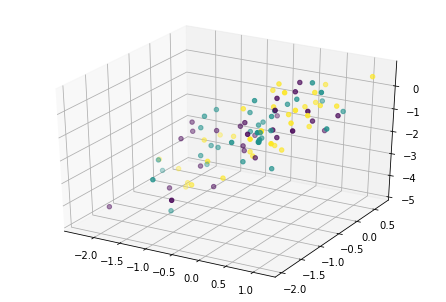

In [325]:
def data_generator(alpha, b, mu0, lambda0, W, nu, N, nlabel, ntopic, d, T):
    rho = np.random.dirichlet(alpha*np.ones((k0+k1)), 1)[0]
    a = np.random.exponential(1/b,1)[0]
    G = np.random.dirichlet(a*rho,N)
    Y = np.random.choice(list(range(nlabel)),N)
    
#     T = []
#     for i in range(nlabel):
#         tem = np.block([
#             [np.zeros((k0*i,k0+k1))],
#             [np.eye(k0), np.zeros((k0, k1))],
#             [np.zeros((k0*(nlabel-i-1),k0+k1))],
#             [np.zeros((k1,k0)), np.eye(k1)]
#         ])
#         T.append(tem)

    U = np.array([np.dot(T[Y[i]], G[i]) for i in range(N)])
    
#     ntopic = 3
    s_inv = wishart.rvs(df = nu, scale = W, size=ntopic) # sigma inverse
#     print(s_inv)
    s2 = np.array([i.flatten() for i in s_inv]) # flatten s_inv
#     print(s2)
#     s3 = np.array([i.reshape(d,d) for i in s2])
#     print(s3)

    mu = np.array([np.random.multivariate_normal(mu0, 1/lambda0*np.linalg.inv(i)) for i in s_inv])
#     print(mu)
    tao = np.array([np.dot(s_inv[i], mu[i]) for i in range(ntopic)])
#     print(tao)

    X = []
    
    for i in range(N):
        tems = np.linalg.inv(np.dot(s2.T, U[i]).reshape(d,d))
        t2 = np.dot(tao.T, U[i])
        temmu = np.dot(tems, t2)
        tem = np.random.multivariate_normal(temmu, tems)
        X.append(tem)
    X = np.array(X)
#     print(X)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c =Y)

    return rho, a, X, Y, U, G, s_inv, mu

rho, a, X, Y, U, G, s_inv, mu = data_generator(alpha, b, mu0, lambda0, W, nu, N, nlabel, ntopic, d, T)


1.7784340763989481
[3.37743214e-02 8.39317286e-02 2.31344025e-04 2.27026523e-04
 8.16994761e-03 8.63843838e-01 9.82179337e-03]


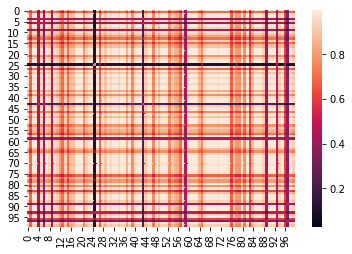

In [326]:
print(a)
print(rho)
sns.heatmap(np.dot(U,U.T))

In [327]:
iter = 5000

In [328]:
def p1(rho, alpha):
    return dirichlet.logpdf(rho, alpha)
def p2(a, b):
    return expon.logpdf(a, loc = 0, scale = 1/b)
def p3(g, alpha):
    return dirichlet.logpdf(g, alpha)
def logpx(x, s, mu):
    return 0.5*np.log(np.linalg.det(s))-0.5*np.dot(np.dot((x-mu).T, s), x-mu)

0.35781186484424876 [0.15193788 0.1781415  0.09232603 0.13013858 0.08248895 0.1969798
 0.16798726]
(100, 11)


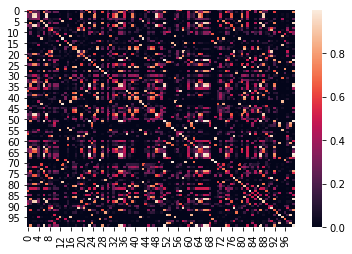

In [329]:
def gibbs(X, Y, alpha, b, mu0, lambda0, W, nu, T, time, k0, k1, d, s_inv, mu):
    '''
    input: data, hyperparameters, T, # iterations
    output: rho, a, g, theta (mu, s_inv)
    '''
    #initialization
    dg = k0 + k1
    rho = np.random.dirichlet(alpha*np.ones((dg)), 1)[0]
    a = np.random.exponential(1/b,1)[0]
#     G = np.random.dirichlet(a*rho,N)
    G = np.random.dirichlet(alpha*np.ones((dg)),N)
#     s_inv = wishart.rvs(df = nu, scale = W, size=ntopic) # sigma inverse
    s2 = np.array([i.flatten() for i in s_inv]) # flatten s_inv
#     mu = np.array([np.random.multivariate_normal(mu0, 1/lambda0*np.linalg.inv(i)) for i in s_inv])
    tao = np.array([np.dot(s_inv[i], mu[i]) for i in range(ntopic)])
    W_inv = np.linalg.inv(W)
#     N = len(Y)
#     for g in G:
#         print(g)
#         p3(g, a*nrho)
    for t in range(time):
        # update g_1:N
        for i in range(N):
            newg = np.random.dirichlet(alpha*np.ones((dg)), 1)[0]
            newu = np.dot(T[Y[i]], newg)
            tems = np.linalg.inv(np.dot(s2.T, newu).reshape(d,d))
            t2 = np.dot(tao.T, newu)
            temmu = np.dot(tems, t2)
            newp = logpx(X[i],tems, temmu) + (np.log(newg) * (a*rho-1)).sum()
            
            oldg = G[i]
            oldu = np.dot(T[Y[i]], oldg)
            tems = np.linalg.inv(np.dot(s2.T, oldu).reshape(d,d))
            t2 = np.dot(tao.T, oldu)
            temmu = np.dot(tems, t2)
            oldp = logpx(X[i],tems, temmu) + (np.log(oldg) * (a*rho-1)).sum()
            
#             print(newp-oldp)
            ag = min(1, np.exp(min(1,newp-oldp)))
            u = np.random.uniform()
            if u < ag:
#                 print("update g",i)
                G[i] = newg
        
        # update rho
#         nrho = np.random.dirichlet(alpha*np.ones((k0+k1)), 1)[0]
#         newrho = np.random.dirichlet(alpha*np.ones((dg)), 1)[0]
#         newp = (alpha - 1)*np.log(newrho).sum() - N*sc.gammaln(a*newrho).sum() + ((a*newrho-1)*np.log(G)).sum()
#         oldp = (alpha - 1)*np.log(oldrho).sum() - N*sc.gammaln(a*oldrho).sum() + ((a*rho-1)*np.log(G)).sum()
#         arho = min(1, np.exp(newp-oldp))
#         u = np.random.uniform()
#         if u < ag:
# #                 print("update rho")
#             rho = newrho
#         print(G.shape)
        rho = np.mean(G, axis=0)
    
        # update a
#         newa = np.random.exponential(1/b,1)[0]
#         newp = (alpha - 1)*np.log(rho).sum() + N*sc.gammaln(newa) - N*sc.gammaln(newa*rho).sum() + ((newa*rho-1)*np.log(G)).sum()
#         oldp = (alpha - 1)*np.log(rho).sum() + N*sc.gammaln(a) - N*sc.gammaln(a*rho).sum() + ((a*rho-1)*np.log(G)).sum()
#         aa = min(1, np.exp(newp-oldp))
#         u = np.random.uniform()
#         if u < aa:          
#             print("update u")
#             a = newa
        tem = G[:,1]
        E1 = np.mean(tem)
        E2 = np.mean(tem*tem)
        a = (E1-E2)/(E2-E1**2)
        
        # update Theta
#         for k in range(ntopic):
#             nk = G[:, k].sum()
#             xbar = np.dot(X.T, G[:, k])/nk
#             lambdak = lambda0 + nk
#             muk = (lambda0*mu0+nk*xbar)/lambdak
#             nuk = nu + nk
#             X2 = np.array([np.dot((i-xbar).T,i-xbar).flatten() for i in X])
#             Wk_inv = W_inv + np.dot(X2.T, G[:, k]).reshape(d,d) + nk*lambda0/lambdak*np.dot((xbar-mu0).T,xbar-mu0)
#             Wk = np.linalg.inv(Wk_inv)
#             s_inv_k = wishart.rvs(df = nu, scale = W, size=1)[0]
#             mu_k = np.random.multivariate_normal(muk, 1/lambdak*np.linalg.inv(s_inv_k))
#             s_inv[k] = s_inv_k
#             mu[k] = mu_k

#         s2 = np.array([i.flatten() for i in s_inv]) # flatten s_inv
#         tao = np.array([np.dot(s_inv[i], mu[i]) for i in range(ntopic)])

    print(a, rho)
#     print(U.shape)
    U = np.array([np.dot(T[Y[i]], G[i]) for i in range(N)])
    print(U.shape)
    sns.heatmap(np.dot(U,U.T))
    
    
 




    
        
#         nrho = np.random.dirichlet(alpha*np.ones((k0+k1)), 1)[0]
#         sum([p3(g, a*nrho) for g in G])
#         ar = min(1, np.exp(sum([p3(g, a*nrho) for g in G]) - sum([p3(g, a*rho) for g in G])))
#         u = np.random.uniform()
#         if u < ar:
#             rho = nrho
#         print(1)
#         na = np.random.exponential(1/b,1)[0]
#         aa = min(1, np.exp(sum([p3(g, na*rho) for g in G]) - sum([p3(g, a*rho) for g in G])))
#         u = np.random.uniform()
#         if u < ar:
#             a = na
#         print(2)

iter = 5000
gibbs(X, Y, alpha, b, mu0, lambda0, W, nu, T, iter, k0, k1, d, s_inv, mu)